In [1]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# Path to the dataset
dataset_dir='ravdess-emotional-speech-audio'

In [3]:
# Emotion dictionary mapping file name codes to emotion labels
emotion_dict = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

In [5]:
# Initialize lists to store features and labels
features = []
labels = []

# Process each audio file
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.wav'):
            # Extract emotion from file name
            emotion = emotion_dict[file.split('-')[2]]
            file_path = os.path.join(root, file)
            
            # Extract features
            mfccs = extract_features(file_path)
            features.append(mfccs)
            labels.append(emotion)

In [6]:
# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

In [7]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [8]:
# Save the label encoder for future use
import joblib
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [9]:
# Save features and labels
np.save('features.npy', X)
np.save('labels.npy', y_encoded)

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [11]:
# Load features and labels
X = np.load('features.npy')
y = np.load('labels.npy')

In [12]:
# Reshape features for CNN
X = X[..., np.newaxis]  # Add channel dimension
y = to_categorical(y)  # One-hot encode labels

In [13]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Save the test set for later use
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [15]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.2172 - loss: 2.9656 - val_accuracy: 0.2900 - val_loss: 1.8211
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3872 - loss: 1.6401 - val_accuracy: 0.3593 - val_loss: 1.6044
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4627 - loss: 1.4462 - val_accuracy: 0.4805 - val_loss: 1.3500
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5766 - loss: 1.1393 - val_accuracy: 0.5758 - val_loss: 1.1118
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7023 - loss: 0.8914 - val_accuracy: 0.6580 - val_loss: 0.9568
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7460 - loss: 0.7243 - val_accuracy: 0.7229 - val_loss: 0.8147
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8067 - loss: 0.5564 - val_accuracy: 0.6883 - val_loss: 0.7594
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8314 - loss: 0.4567 - val_accuracy: 0.7619 - v

In [17]:
# Evaluate the model
scores = model.evaluate(X_test, y_test)
print(f"Accuracy: {scores[1]*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9267 - loss: 0.4607
Accuracy: 92.36%


In [18]:
# Save the model
import joblib
model.save('voice_emotion_recognition.h5')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


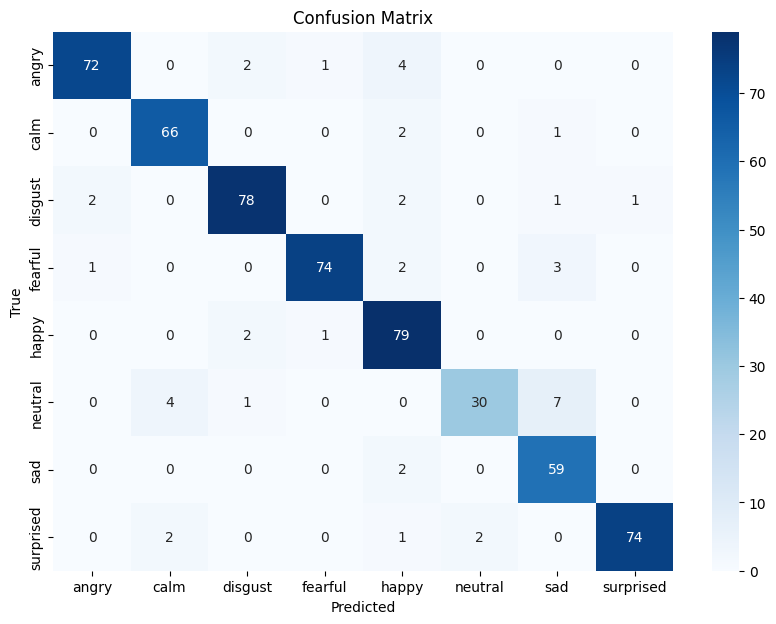

In [21]:
import numpy as np
import joblib
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

# Load the saved model and label encoder
model = load_model('voice_emotion_recognition.h5')
label_encoder = joblib.load('label_encoder.pkl')

# Load the test set features and labels
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Recompile the model to suppress warnings (optional)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Make predictions
y_pred = model.predict(X_test)

# Convert predictions and true labels to original label encoding
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Classification Report:
               precision    recall  f1-score   support

       angry       0.96      0.91      0.94        79
        calm       0.92      0.96      0.94        69
     disgust       0.94      0.93      0.93        84
     fearful       0.97      0.93      0.95        80
       happy       0.86      0.96      0.91        82
     neutral       0.94      0.71      0.81        42
         sad       0.83      0.97      0.89        61
   surprised       0.99      0.94      0.96        79

    accuracy                           0.92       576
   macro avg       0.93      0.91      0.92       576
weighted avg       0.93      0.92      0.92       576



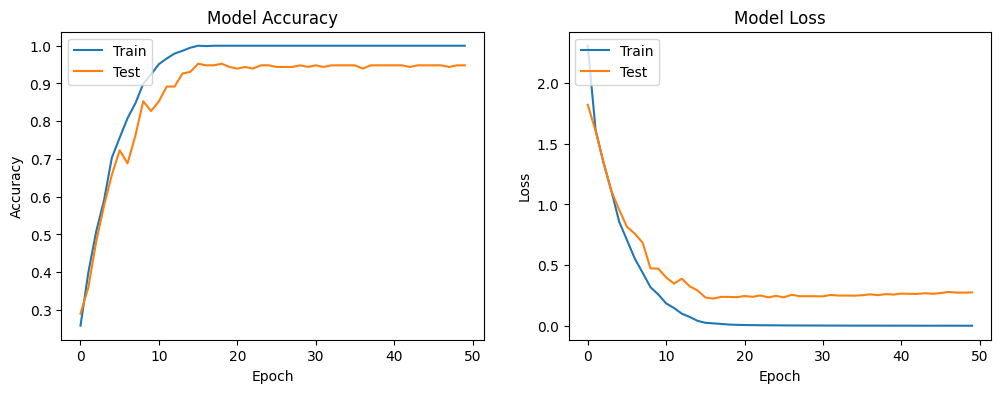

In [22]:
# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [2]:
#EMOTION DETECTION WITHOUT AUDIO 
import cv2
import numpy as np
import librosa
import joblib
from keras.models import load_model
import moviepy.editor as mp

# Load the trained model and label encoder
model = load_model('voice_emotion_recognition.h5')
label_encoder = joblib.load('label_encoder.pkl')

# Function to extract features from an audio chunk
def extract_features(audio_chunk, sr):
    mfccs = librosa.feature.mfcc(y=audio_chunk, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

# Function to predict emotion from audio chunk
def predict_audio_emotion(audio_chunk, sr):
    features = extract_features(audio_chunk, sr)
    features = np.reshape(features, (1, -1, 1))
    prediction = model.predict(features)
    label = label_encoder.inverse_transform([np.argmax(prediction)])
    return label[0]

# Load the video
video_path = 'sample2.mp4'  # Update with your video path
video = cv2.VideoCapture(video_path)

# Extract audio from the video
clip = mp.VideoFileClip(video_path)
audio = clip.audio
sr = 16000  # Sample rate

# Loop through the video frames and process audio
frame_number = 0
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    # Process audio in chunks of 1 second
    start_time = frame_number / video.get(cv2.CAP_PROP_FPS)
    end_time = start_time + 1  # 1-second chunk
    audio_chunk = audio.subclip(start_time, end_time).to_soundarray(fps=sr)
    audio_chunk = audio_chunk.mean(axis=1)  # Convert to mono

    # Predict emotion
    emotion_label = predict_audio_emotion(audio_chunk, sr)

    # Display emotion label on video frame
    cv2.putText(frame, f'Emotion: {emotion_label}', (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Show the video frame
    cv2.imshow('Video with Emotion Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_number += 1

# Release video capture and close windows
video.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [ ]:
#EMOTION DETECTION WITH AUDIO 
import cv2
import numpy as np
import pyaudio
import librosa
import joblib
from keras.models import load_model
import moviepy.editor as mp
import threading

# Load the trained model and label encoder
model = load_model('voice_emotion_recognition.h5')
label_encoder = joblib.load('label_encoder.pkl')

# Function to extract features from an audio chunk
def extract_features(audio_chunk, sr):
    mfccs = librosa.feature.mfcc(y=audio_chunk, sr=sr, n_mfcc=40)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

# Function to predict emotion from audio chunk
def predict_audio_emotion(audio_chunk, sr):
    features = extract_features(audio_chunk, sr)
    features = np.reshape(features, (1, -1, 1))
    prediction = model.predict(features)
    label = label_encoder.inverse_transform([np.argmax(prediction)])
    return label[0]

# Function to play audio
def play_audio(audio_chunk, sr):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=sr, output=True)
    stream.write(audio_chunk.astype(np.float32).tobytes())
    stream.stop_stream()
    stream.close()
    p.terminate()

# Load the video
video_path = 'sample1.mp4'  # Update with your video path
video = cv2.VideoCapture(video_path)

# Extract audio from the video
clip = mp.VideoFileClip(video_path)
audio = clip.audio
sr = 16000  # Sample rate

# Video playback and audio processing loop
frame_number = 0
chunk_size = sr  # 1 second of audio
while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    # Process audio in chunks
    start_time = frame_number / video.get(cv2.CAP_PROP_FPS)
    end_time = start_time + 1  # 1-second chunk
    audio_chunk = audio.subclip(start_time, end_time).to_soundarray(fps=sr)
    audio_chunk = audio_chunk.mean(axis=1)  # Convert to mono

    # Predict emotion
    emotion_label = predict_audio_emotion(audio_chunk, sr)

    # Display emotion label on video frame
    cv2.putText(frame, f'Emotion: {emotion_label}', (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Play audio in a separate thread
    threading.Thread(target=play_audio, args=(audio_chunk, sr)).start()

    # Show the video frame
    cv2.imshow('Video with Emotion Detection', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_number += 1

# Release video capture and close windows
video.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━